# Variational Autoencoders

Here we introduce variational encoders which, given data $(x_i)_{i=1}^m$, attempt to estimate the probability distribution $p(x)$ that generated the data. We assume that the data is defined by latent variables $z$ and that the marginal w.r.t $z$ of the joint distribution $p(x,z)$ is a standard Gaussian, i.e., $p(z)\sim N(0,I)$.

The approach of the variational encoder is to `learn' the latent representation of data $x$ (i.e., $p(z|x)$ -- a probabilistic encoding), as well as the reconstruction $p(x|z)$, i.e., a probabilistic decoding.

Both, $p(x|z)$ as well as $p(z|x)$ are learned using neural networks: $p(x|z)\sim N(f(z,\theta),I)$ and 
$p(z|x)\sim N(f_\mu(x,\eta_\mu),f_{\sigma}(x,\eta_\sigma))$, and $f(z,\theta), f_\mu(x,\eta_\mu),f_{\sigma}(x,\eta_\sigma)$ are neural networks.

To train the variational autoencoder we want that $p(x|z)p(z|x)$ be maximized (so that data is actually well represented), and we also want to push the conditional distribution $p(z|x)$ to be as close to a standard Gaussian as possible. 

The loss function therefore consists of a representation loss $|x-f(z,\theta)|^2$, where $z$ is drawn from $N(f_\mu(x,\eta_\mu),f_{\sigma}(x,\eta_\sigma))$, and a distribution loss $D_{KL}(N(f_\mu(x,\eta_\mu),f_{\sigma}(x,\eta_\sigma))||N(0,I))$, which can be evaluated explicitly (see the code below).

Since the node which samples from $N(f_\mu(x,\eta_\mu),f_{\sigma}(x,\eta_\sigma))$ cannot be differentiated, one resorts to the `reparametrization trick': create an input node which draws $\varepsilon$ from $N(0,I)$ and 
a deterministic node which computes $f_\mu(x,\eta_\mu)+\varepsilon \cdot f_{\sigma}(x,\eta_\sigma)$. The resulting architecture can be trained using backprop.

Often, the logarithm of $f_{\sigma}(x,\eta_\sigma)$ is learned, instead of $f_{\sigma}(x,\eta_\sigma)$; this does not change the algorithm but results in better performance.

We may now "generate data" by drawing $z$ according to $N(0,I)$ and applying $f(z,\theta)$.

...and here comes the implementation...

Import libraries

In [1]:
#import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os #for creating output directory
from tensorflow.examples.tutorials.mnist import input_data

Set hyperparameters

In [2]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
mb_size = 64 #minibatch size
z_dim = 100 #dimension of latent variable
X_dim = mnist.train.images.shape[1] #dimension of data
h_dim = 128 #dimension of hidden layer
lr = 1e-3 #learning rate

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Define auxiliary routines

In [3]:
#define plotting routine
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

Initialization

In [4]:
#define initialization
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

Define Encoder

In [5]:
# define the encoder
X = tf.placeholder(tf.float32, shape=[None, X_dim])

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))

#define networks for mean and log-variance
def Q(X):
    h = tf.nn.elu(tf.matmul(X, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

#draw sample from encoder
def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

Define Decoder

In [6]:
# define decoder
z = tf.placeholder(tf.float32, shape=[None, z_dim])

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

# output value of decoder, both with linear output unit and logit unit
def P(z):
    h = tf.nn.elu(tf.matmul(z, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

Define Training and run the model

Iter: 0
Loss: 850.3
()


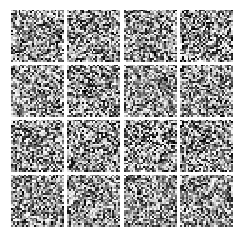

Iter: 1000
Loss: 149.4
()


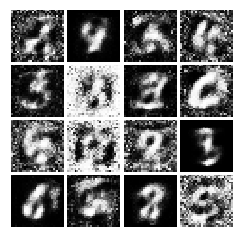

Iter: 2000
Loss: 138.4
()


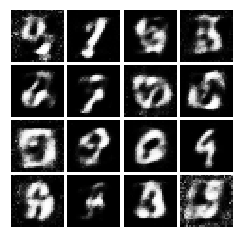

Iter: 3000
Loss: 127.7
()


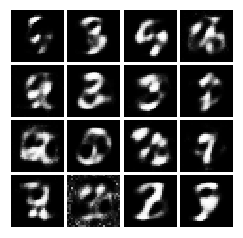

Iter: 4000
Loss: 116.3
()


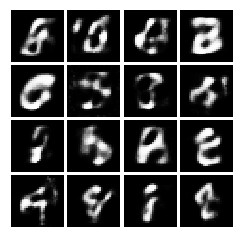

Iter: 5000
Loss: 116.1
()


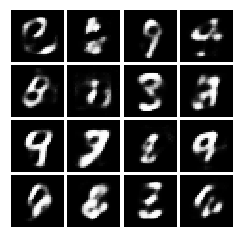

Iter: 6000
Loss: 118.7
()


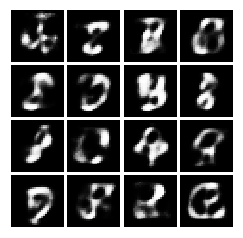

Iter: 7000
Loss: 113.0
()


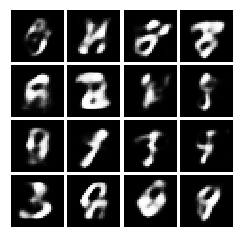

Iter: 8000
Loss: 113.6
()


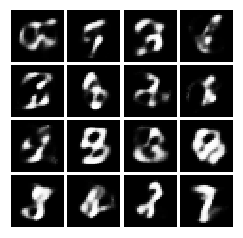

Iter: 9000
Loss: 113.6
()


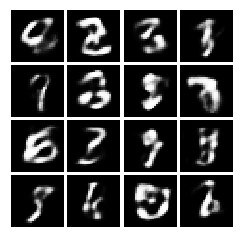

Iter: 10000
Loss: 112.6
()


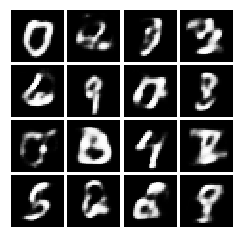

Iter: 11000
Loss: 105.8
()


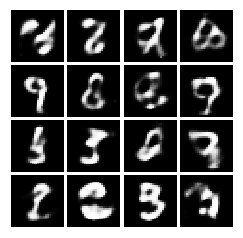

Iter: 12000
Loss: 115.0
()


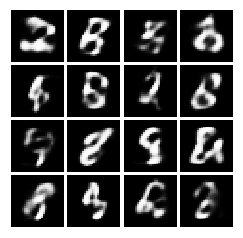

Iter: 13000
Loss: 110.4
()


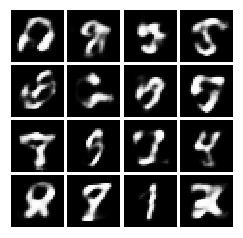

Iter: 14000
Loss: 106.2
()


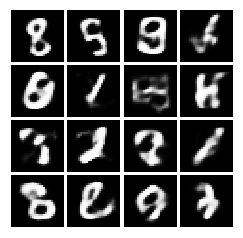

Iter: 15000
Loss: 116.4
()


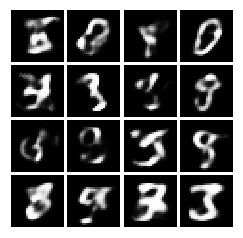

Iter: 16000
Loss: 106.8
()


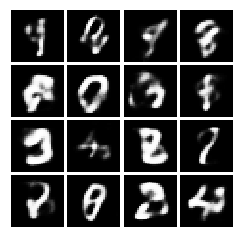

Iter: 17000
Loss: 113.6
()


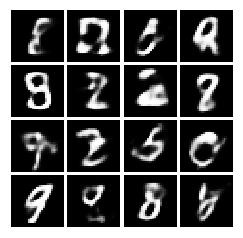

Iter: 18000
Loss: 112.3
()


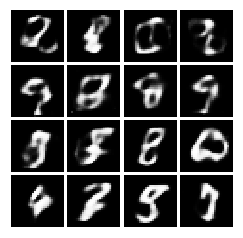

Iter: 19000
Loss: 114.7
()


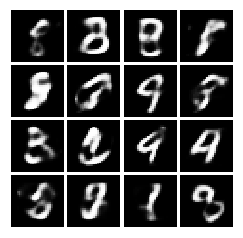

Iter: 20000
Loss: 108.3
()


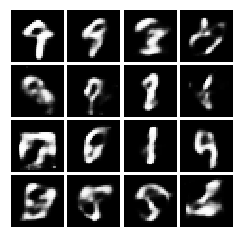

Iter: 21000
Loss: 107.8
()


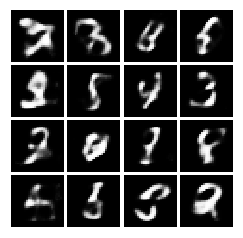

Iter: 22000
Loss: 114.2
()


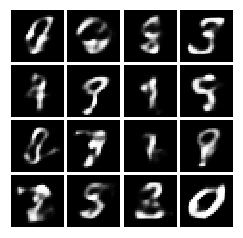

Iter: 23000
Loss: 108.4
()


KeyboardInterrupt: 

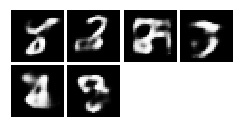

In [7]:
#train the VAE

z_mu, z_logvar = Q(X) #node for evaluating mean and logvar
z_sample = sample_z(z_mu, z_logvar) #node for sampling encoder
_, logits = P(z_sample) #node for decoder

# Sampling from random z
X_samples, _ = P(z)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

#make directory for output
if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(1000000):
    X_mb, _ = mnist.train.next_batch(mb_size) #get new minibatch

    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(16, z_dim)}) #generte 16 random samples 
                                                                                 #from trained VAE

        fig = plot(samples)
        #plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        plt.show()
        i += 1
        plt.close(fig)